# Stock market forecasting with prophet

* Ref: [https://pythondata.com/stock-market-forecasting-with-prophet/](https://pythondata.com/stock-market-forecasting-with-prophet/)
* Data: [https://fred.stlouisfed.org/series/SP500](https://fred.stlouisfed.org/series/SP500)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
from IPython.display import display

## 1. Load data

In [3]:
# Load data from google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/SP500.csv',
                 index_col=0,
                 parse_dates=True)
df.head()

,SP500
DATE,
2015-09-04,1921.22
2015-09-07,.
2015-09-08,1969.41
2015-09-09,1942.04
2015-09-10,1952.29


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1306 entries, 2015-09-04 to 2020-09-04
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SP500   1306 non-null   object
dtypes: object(1)
memory usage: 20.4+ KB


* 注意: 2015-09-07 那一列 SP500 的值是 . 所以會有問題，檢查後發現有很多日子是 . 所以要把這些日子丟掉

In [6]:
df[df['SP500']=='.'].head()

,SP500
DATE,
2015-09-07,.
2015-11-26,.
2015-12-25,.
2016-01-01,.
2016-01-18,.


In [7]:
df = df[df['SP500']!='.']
df['SP500'] = df['SP500'].astype(float)
df.head()

,SP500
DATE,
2015-09-04,1921.22
2015-09-08,1969.41
2015-09-09,1942.04
2015-09-10,1952.29
2015-09-11,1961.05


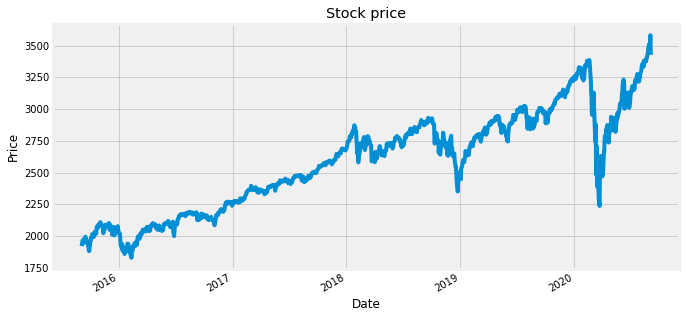

In [8]:
# visualization
fig, ax = plt.subplots(figsize=(10, 5))
df['SP500'].plot(ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Stock price')
plt.show()

* 把 dataframe 改成是 prophet 吃的格式

In [9]:
df.reset_index(inplace=True)
df.rename(columns={'DATE': 'ds', 'SP500': 'y'}, inplace=True)
df.head()

,ds,y
0,2015-09-04,1921.22
1,2015-09-08,1969.41
2,2015-09-09,1942.04
3,2015-09-10,1952.29
4,2015-09-11,1961.05


## 2. Analysis
* 可以檢查是否是 stationary
  * Prophet 好像沒有要求 time series 是 stationary 的

In [10]:
def adf_test(time_series):
    # perform Dickey-Fuller test
    # null hypothesis: the time series is non-stationary 
    from statsmodels.tsa.stattools import adfuller # Use augmented dickey-fuller test to check stationality

    print('Results of Dickey-Fuller test:')
    adf_test = adfuller(time_series, autolag='AIC') # AIC: Akaike information criterion (AIC), the smaller AIC the better model

    index = [
      'Test statistics (ADF)',
      'p-value',
      'Number of lags used',
      'Number of observations used'
    ]
    adf_results = pd.Series(adf_test[:4], index=index)

    for k, v in adf_test[4].items():
        adf_results[f'Critical value ({k})'] = v

    print(adf_results)

    if adf_results[1] <= 0.05:
        print('Because p <= 0.05, we reject the null hypothesis')
        print('--> The time series is stationary')
    else:
        print('The time series is non-stationary')

In [11]:
adf_test(df['y'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Results of Dickey-Fuller test:
Test statistics (ADF)            -1.149869
p-value                           0.694781
Number of lags used               9.000000
Number of observations used    1250.000000
Critical value (1%)              -3.435592
Critical value (5%)              -2.863855
Critical value (10%)             -2.568003
dtype: float64
The time series is non-stationary


* time series 不是 stationary 所以可以做 differencing 或是取 log 等等的方式讓它變成 stationary，這裡採用取 log 的方式

In [13]:
import numpy as np
df['y'] = np.log(df['y'])
df.head()

,ds,y
0,2015-09-04,7.560716
1,2015-09-08,7.585489
2,2015-09-09,7.571494
3,2015-09-10,7.576758
4,2015-09-11,7.581235


* 取完 log 之後再檢查一次是不是 stationary 的

In [14]:
adf_test(df['y'])

Results of Dickey-Fuller test:
Test statistics (ADF)            -1.250452
p-value                           0.651525
Number of lags used               9.000000
Number of observations used    1250.000000
Critical value (1%)              -3.435592
Critical value (5%)              -2.863855
Critical value (10%)             -2.568003
dtype: float64
The time series is non-stationary


## 3. Forecast

In [19]:
from fbprophet import Prophet

# Fitting
model = Prophet() # 這裡可以加上參數改變 conf_int (預設用 80%) 或是選擇要不要 seasonality 等等的
model.fit(df)

# 建立一個要預測的 dataframe
df_future = model.make_future_dataframe(periods=365) # 預測未來一年的股價

# Forecast
df_forecast = model.predict(df_future) # df_forecast 包含了 train 和 future 的日期的預測的結果
df_forecast.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-09-04,7.525950,7.524756,7.593939,7.525950,7.525950,0.034583,0.034583,0.034583,-0.004654,-0.004654,-0.004654,0.039236,0.039236,0.039236,0.0,0.0,0.0,7.560532
1,2015-09-08,7.529736,7.533745,7.603800,7.529736,7.529736,0.038153,0.038153,0.038153,-0.003643,-0.003643,-0.003643,0.041796,0.041796,0.041796,0.0,0.0,0.0,7.567889
2,2015-09-09,7.530682,7.534715,7.602906,7.530682,7.530682,0.038647,0.038647,0.038647,-0.003585,-0.003585,-0.003585,0.042232,0.042232,0.042232,0.0,0.0,0.0,7.569330
3,2015-09-10,7.531629,7.535182,7.604479,7.531629,7.531629,0.038302,0.038302,0.038302,-0.004298,-0.004298,-0.004298,0.042600,0.042600,0.042600,0.0,0.0,0.0,7.569931
4,2015-09-11,7.532575,7.537185,7.605149,7.532575,7.532575,0.038255,0.038255,0.038255,-0.004654,-0.004654,-0.004654,0.042909,0.042909,0.042909,0.0,0.0,0.0,7.570831


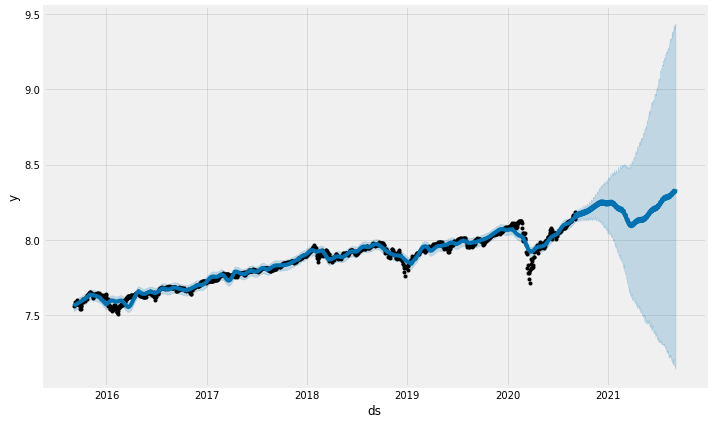

In [20]:
# visualization
fig = model.plot(df_forecast)

* 雖然預測出來的中央值好像還不壞，但是 confidence interval 太大了，所以表示這個預測的結果不是很好
* 可以看得到 trend 但是預測的值並不是很精準

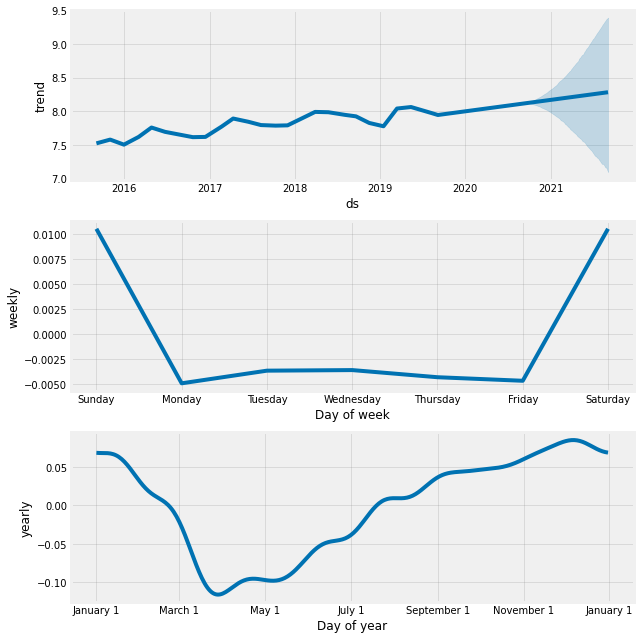

In [21]:
# visualization
fig = model.plot_components(df_forecast)

* 如果只看 2014-08 到 2017-08 的結果

,y
ds,
2015-09-04,7.560716
2015-09-08,7.585489
2015-09-09,7.571494
2015-09-10,7.576758
2015-09-11,7.581235


,yhat,yhat_lower,yhat_upper
ds,,,
2015-09-04,7.560532,7.524756,7.593939
2015-09-08,7.567889,7.533745,7.603800
2015-09-09,7.569330,7.534715,7.602906
2015-09-10,7.569931,7.535182,7.604479
2015-09-11,7.570831,7.537185,7.605149


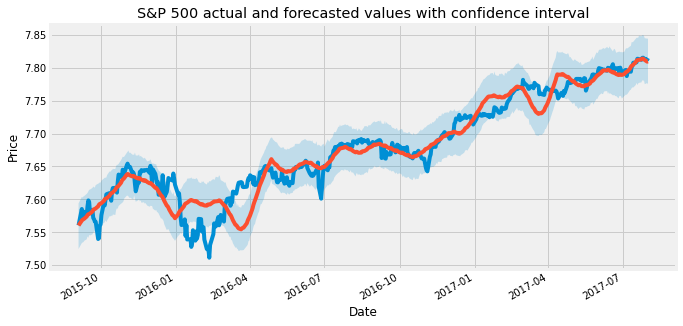

In [22]:
df_sub = df.set_index('ds').loc['2014-08-01':'2017-08-01']
df_forecast_sub = df_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].set_index('ds').loc['2014-08-01':'2017-08-01']

display(df_sub.head())
display(df_forecast_sub.head())

# visualization
fig, ax = plt.subplots(figsize=(10, 5))
df_sub['y'].plot(ax=ax, label='Actual')
df_forecast_sub['yhat'].plot(ax=ax, label='Forecast')
ax.fill_between(df_forecast_sub.index, df_forecast_sub['yhat_lower'], df_forecast_sub['yhat_upper'], alpha=0.2)
ax.set_title('S&P 500 actual and forecasted values with confidence interval')
ax.set_ylabel('Price')
ax.set_xlabel('Date')
plt.show()

* 檢查 metrics
  * 看 y_true 和 y_pred 的誤差
  * $R^2$ score: 越接近 1 越好
  * MSE: 越小越好
  * MAE

In [23]:
s_err = df_sub['y'] - df_forecast_sub['yhat']
s_err.describe()

count    480.000000
mean       0.000283
std        0.022719
min       -0.080734
25%       -0.010415
50%        0.001538
75%        0.010668
max        0.071798
dtype: float64

In [27]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

r2 = r2_score(df_sub['y'], df_forecast_sub['yhat'])
mse = mean_squared_error(df_sub['y'], df_forecast_sub['yhat'])
mae = mean_absolute_error(df_sub['y'], df_forecast_sub['yhat'])
print(f'R^2 score={r2}, mse={mse}, mae={mae}')

R^2 score=0.9071876826036862, mse=0.0005151431973893533, mae=0.015975157945563236


* 看起來 2014-08 到 2017-08 預測到的結果還不差